In [1]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.timeseries import LombScargle

First, extract data and plot magnitude and error plots, just to check the errorbars are similar (e.g. there could be some extra correction/errors on the mag-to-flux correction that the ASSASN folks are adding):

In [2]:
# Extract data:
t, m, merr, f, ferr = np.loadtxt('AP37212727.csv', delimiter = ',', usecols=(0, 3, 4, 5, 6), unpack=True)

<ErrorbarContainer object of 3 artists>

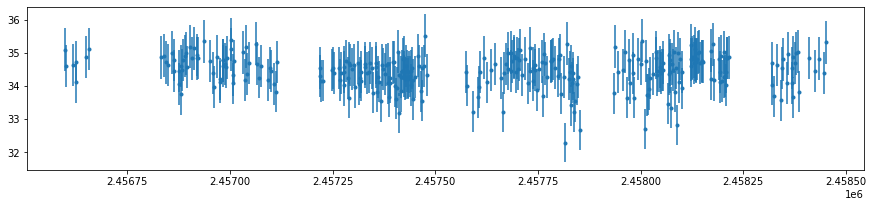

In [3]:
# Plot:
plt.figure(figsize = (15,3))
plt.errorbar(t, f, ferr, fmt = '.')

<ErrorbarContainer object of 3 artists>

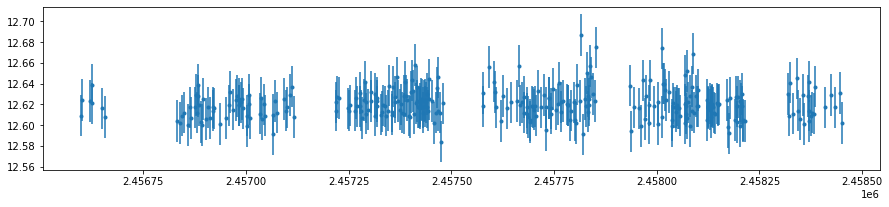

In [4]:
# Plot:
plt.figure(figsize = (15,3))
plt.errorbar(t, m, merr, fmt = '.')

They look pretty similar to me! I'll work with fluxes then. Let's normalize the fluxes:

Text(0, 0.5, 'Relative flux')

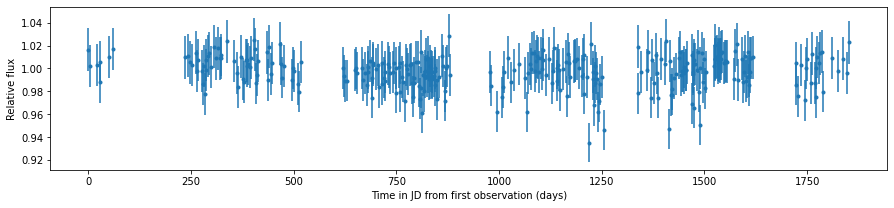

In [5]:
median_flux = np.median(f)
f = f / median_flux
ferr = ferr / median_flux

plt.figure(figsize = (15,3))

plt.errorbar(t - np.min(t), f, ferr, fmt = '.')
plt.xlabel('Time in JD from first observation (days)')
plt.ylabel('Relative flux')

Great! Let's now remove all in-transit points:

In [6]:
P, t0 = 4.76339146, 2459198.51299

# Get phases:
phases = ((t - np.median(t0))/np.median(P)) % 1
ii = np.where(phases>=0.5)[0]
phases[ii] = phases[ii]-1.0
    
# Get phases out-of-transit --- assume Tdur = 4 hours just in case:
idx = np.where( np.abs(phases) * P * 24. >= 2. )[0]

Let's plot the phased lightcurve:

(-10.0, 10.0)

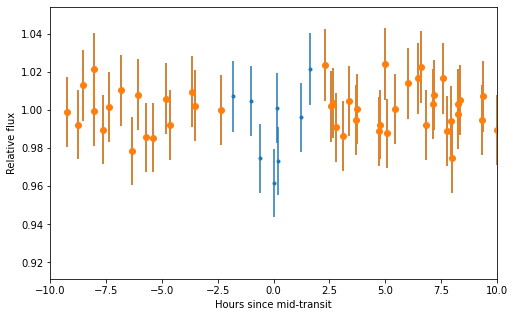

In [7]:
plt.figure(figsize = (8,5))
plt.errorbar(phases * P * 24., f, ferr, fmt = '.')
plt.errorbar(phases[idx] * P * 24., f[idx], ferr[idx], fmt = 'o')
plt.xlabel('Hours since mid-transit')
plt.ylabel('Relative flux')
plt.xlim(-10,10)

Hey, I kind of see the transits! Let's plot the in and out-of-transit points on the time-series:

Text(0, 0.5, 'Relative flux')

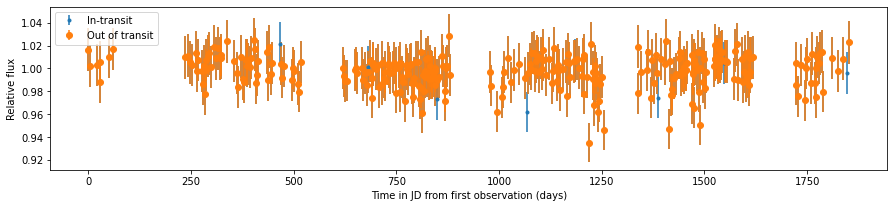

In [8]:
plt.figure(figsize = (15,3))

plt.errorbar(t - np.min(t), f, ferr, fmt = '.', label = 'In-transit')
plt.errorbar(t[idx] - np.min(t), f[idx], ferr[idx], fmt = 'o', label = 'Out of transit')
plt.legend()
plt.xlabel('Time in JD from first observation (days)')
plt.ylabel('Relative flux')

## PSD of the photometry

All right, let's save only the out-of-transit points and play with them:

In [9]:
t, f, ferr = t[idx], f[idx], ferr[idx]

Let's run a periodogram on a frequency grid going from double the average time-stamp to half the observing time-stamp. First, define time-scales:

In [10]:
min_timescale = np.min(np.abs(np.diff(t))) * 2. # Min timescale given by difference of time-stamps.
max_timescale = (np.max(t) - np.min(t)) * 0.5 # Max timescale given by baseline.

frequency = np.linspace(1. / max_timescale, 1. / min_timescale, 10000)

In [11]:
power = LombScargle(t, f, ferr).power(frequency)

Text(0, 0.5, 'PSD')

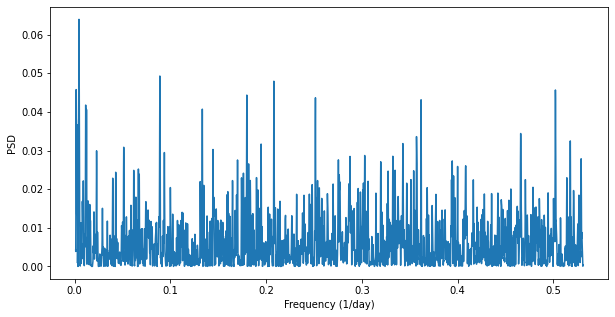

In [12]:
plt.figure(figsize = (10,5))
plt.plot(frequency, power)
plt.xlabel('Frequency (1/day)')
plt.ylabel('PSD')

All right --- so are these peaks consistent with random noise? Let's first generate a set of `nsim` mock time-series with the same properties as the data. Let's create a function to do this:

In [13]:
def mock_dataset(ymedian, yerr, nsim = 10):
    
    ndatapoints = len(yerr)
    
    # Array to store our simulations:
    simulated_data = np.zeros([nsim, ndatapoints])
    
    # Simulate noise:
    for i in range(ndatapoints):
        
        simulated_data[:, i] = np.random.normal(ymedian, yerr[i], nsim)
        
    return simulated_data

In [14]:
simulated_dataset = mock_dataset(np.median(f), ferr)

Let's check one of those time-series matches the actual time-series:

Text(0, 0.5, 'Relative flux')

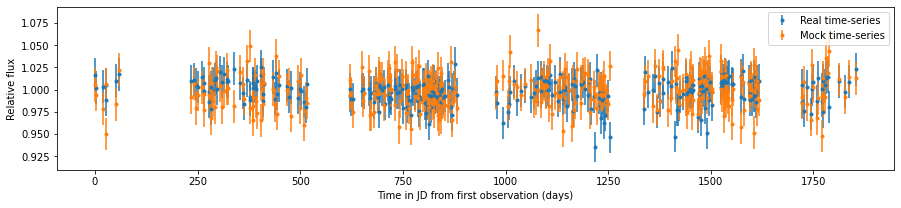

In [15]:
plt.figure(figsize = (15,3))

plt.errorbar(t - np.min(t), f, ferr, fmt = '.', label = 'Real time-series')
plt.errorbar(t - np.min(t), simulated_dataset[0, :], ferr, fmt = '.', label = 'Mock time-series')
plt.legend()
plt.xlabel('Time in JD from first observation (days)')
plt.ylabel('Relative flux')

That's pretty good! Let's now compute the PSD of this mock time-series and compare it against the real one:

In [16]:
mock_power = LombScargle(t, simulated_dataset[0, :], ferr).power(frequency)

Text(0, 0.5, 'PSD')

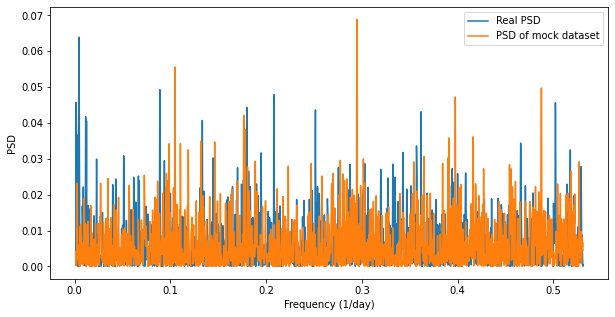

In [17]:
plt.figure(figsize = (10,5))
plt.plot(frequency, power, label = 'Real PSD')
plt.plot(frequency, mock_power, label = 'PSD of mock dataset')
plt.legend()
plt.xlabel('Frequency (1/day)')
plt.ylabel('PSD')

That looks good! Let's now generate a ton of these and compare.

## Generating mock PSDs

Let's generate $10^5$ mock datasets:

In [18]:
nsimulations = 5000
simulated_datasets = mock_dataset(np.median(f), ferr, nsim = nsimulations)

Let's compute the PSD for each of those mock datasets:

In [19]:
simulated_psds = np.zeros([nsimulations, len(frequency)])

for i in range(nsimulations):
    simulated_psds[i, :] = LombScargle(t, simulated_datasets[i, :], ferr).power(frequency)

(That takes a few tens of seconds). With this at hand, let's compute now at each frequency where $99.9\%$, $99\%$ and $90\%$ of the PSDs lie:

In [20]:
nfrequencies = len(frequency)

limit_999 = np.zeros(nfrequencies)
limit_99 = np.zeros(nfrequencies)
limit_90 = np.zeros(nfrequencies)

for i in range(nfrequencies):

    idx = np.argsort(simulated_psds[:, i])

    idx_999 = idx[int(nsimulations * 0.999)]   
    idx_99 = idx[int(nsimulations * 0.99)]
    idx_90 = idx[int(nsimulations * 0.90)]

    limit_999[i] = simulated_psds[idx_999, i]
    limit_99[i] = simulated_psds[idx_99, i]
    limit_90[i] = simulated_psds[idx_90, i]

Plot those limits on the real PSD:

Text(0, 0.5, 'PSD')

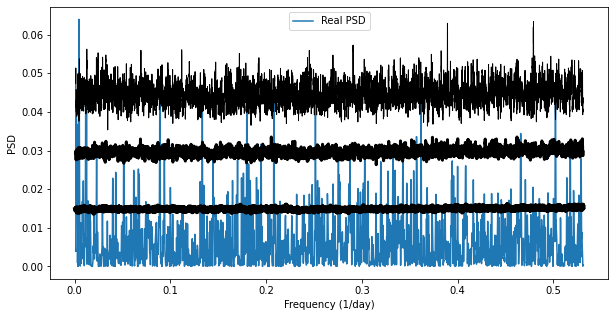

In [21]:
plt.figure(figsize = (10,5))
plt.plot(frequency, power, label = 'Real PSD')
plt.plot(frequency, limit_999, color='black', lw = 1)
plt.plot(frequency, limit_99, color='black', lw = 3)
plt.plot(frequency, limit_90, color='black', lw = 5)
plt.legend()
plt.xlabel('Frequency (1/day)')
plt.ylabel('PSD')

Plot the averages instead:

Text(0, 0.5, 'PSD')

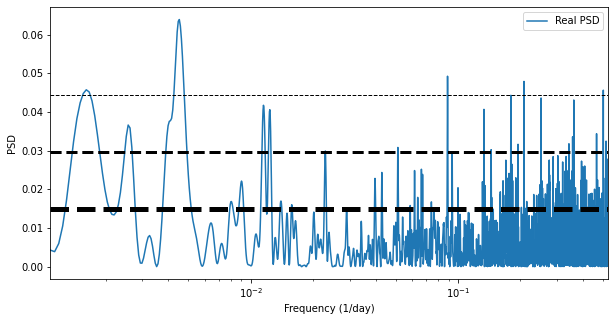

In [22]:
plt.figure(figsize = (10,5))
plt.plot(frequency, power, label = 'Real PSD')
plt.plot([np.min(frequency), np.max(frequency)], [np.median(limit_999), np.median(limit_999)], '--', color='black', lw = 1)
plt.plot([np.min(frequency), np.max(frequency)], [np.median(limit_99), np.median(limit_99)], '--', color='black', lw = 3)
plt.plot([np.min(frequency), np.max(frequency)], [np.median(limit_90), np.median(limit_90)], '--', color='black', lw = 5)
plt.legend()
plt.xlim(np.min(frequency), np.max(frequency))
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Frequency (1/day)')
plt.ylabel('PSD')

Text(0, 0.5, 'PSD')

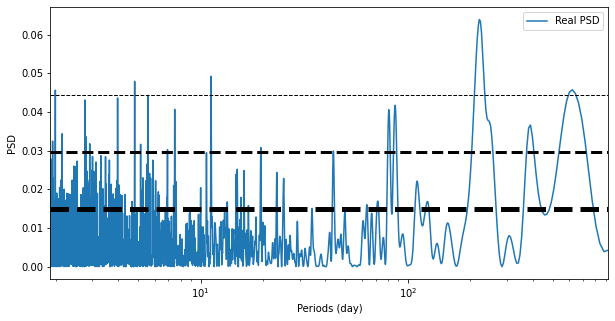

In [23]:
plt.figure(figsize = (10,5))
plt.plot(1./frequency, power, label = 'Real PSD')
plt.plot([1./ np.max(frequency), 1./ np.min(frequency)], [np.median(limit_999), np.median(limit_999)], '--', color='black', lw = 1)
plt.plot([1./ np.max(frequency), 1./ np.min(frequency)], [np.median(limit_99), np.median(limit_99)], '--', color='black', lw = 3)
plt.plot([1./ np.max(frequency), 1./ np.min(frequency)], [np.median(limit_90), np.median(limit_90)], '--', color='black', lw = 5)
plt.legend()
plt.xlim(1./ np.max(frequency), 1./ np.min(frequency))
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Periods (day)')
plt.ylabel('PSD')

Text(0, 0.5, 'PSD')

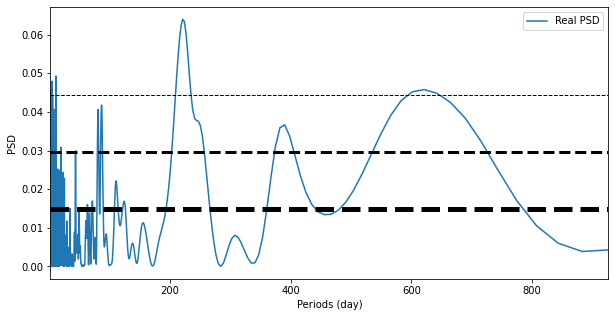

In [24]:
plt.figure(figsize = (10,5))
plt.plot(1./frequency, power, label = 'Real PSD')
plt.plot([1./ np.max(frequency), 1./ np.min(frequency)], [np.median(limit_999), np.median(limit_999)], '--', color='black', lw = 1)
plt.plot([1./ np.max(frequency), 1./ np.min(frequency)], [np.median(limit_99), np.median(limit_99)], '--', color='black', lw = 3)
plt.plot([1./ np.max(frequency), 1./ np.min(frequency)], [np.median(limit_90), np.median(limit_90)], '--', color='black', lw = 5)
plt.legend()
plt.xlim(1./ np.max(frequency), 1./ np.min(frequency))
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Periods (day)')
plt.ylabel('PSD')


Text(0, 0.5, 'PSD')

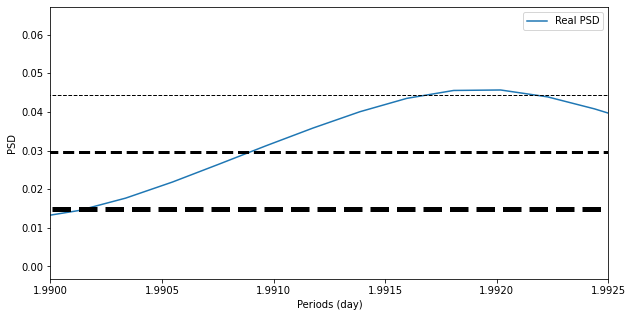

In [25]:
plt.figure(figsize = (10,5))
plt.plot(1./frequency, power, label = 'Real PSD')
plt.plot([1./ np.max(frequency), 1./ np.min(frequency)], [np.median(limit_999), np.median(limit_999)], '--', color='black', lw = 1)
plt.plot([1./ np.max(frequency), 1./ np.min(frequency)], [np.median(limit_99), np.median(limit_99)], '--', color='black', lw = 3)
plt.plot([1./ np.max(frequency), 1./ np.min(frequency)], [np.median(limit_90), np.median(limit_90)], '--', color='black', lw = 5)
plt.legend()
plt.xlim(1.99,1.9925)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Periods (day)')
plt.ylabel('PSD')


Let's get the window function:

In [26]:
WF_power = []

omega = 1/ np.logspace(np.log10(min_timescale), np.log10(max_timescale),  num=len(frequency))

for omi in 2*np.pi*omega: 

    phase = (t - t[0]) * omi
    WC = np.sum(np.cos(phase))
    WS = np.sum(np.sin(phase))
    WF_power.append((WC**2 + WS**2)/len(t)**2) 
 
WF_power = np.array(WF_power)

Text(0, 0.5, 'Window Function')

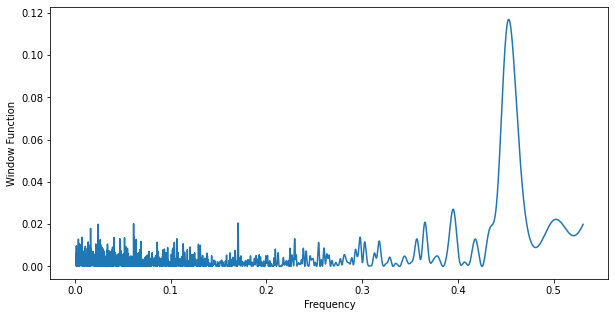

In [27]:
plt.figure(figsize = (10,5))
plt.plot(frequency, WF_power, label = 'Window Function')
plt.xlabel('Frequency')
plt.ylabel('Window Function')

In [28]:
idx = np.where(np.max(WF_power) == WF_power)[0]
print(frequency[idx], 'period:', 1./frequency[idx][0])

[0.45310844] period: 2.206977205427799


In [29]:
possible_periods = [1.992, 4.808, 11.24, 220., 620.]
falias = frequency[idx][0]

print('All peaks in the periodogram:',possible_periods)
print('')
for period in possible_periods:
    print('Period under test:',period)
    print('---------------------------')
    print('Aliases at + 1')
    print(1. / ((1. / period) + falias),'days')
    print('Aliases at - 1')
    print(1. / ((1. / period) - falias),'days')
    print('Aliases at + 2')
    print(1. / ((1. / period) + 2*falias),'days')
    print('Aliases at - 2')
    print(1. / ((1. / period) - 2*falias),'days') 
    print('')

All peaks in the periodogram: [1.992, 4.808, 11.24, 220.0, 620.0]

Period under test: 1.992
---------------------------
Aliases at + 1
1.0469927265928733 days
Aliases at - 1
20.45006857570621 days
Aliases at + 2
0.710113839436821 days
Aliases at - 2
-2.4739685988499307 days

Period under test: 4.808
---------------------------
Aliases at + 1
1.5126416085125043 days
Aliases at - 1
-4.079605309818944 days
Aliases at + 2
0.8975020605491312 days
Aliases at - 2
-1.4321924358864857 days

Period under test: 11.24
---------------------------
Aliases at + 1
1.844758372833077 days
Aliases at - 1
-2.7461929802628466 days
Aliases at + 2
1.0048384450873313 days
Aliases at - 2
-1.2236174171150251 days

Period under test: 220.0
---------------------------
Aliases at + 1
2.185057333934408 days
Aliases at - 1
-2.2293413212418858 days
Aliases at + 2
1.0979812852852386 days
Aliases at - 2
-1.1090514464912928 days

Period under test: 620.0
---------------------------
Aliases at + 1
2.1991490251538424 days

In [30]:
P, t0 = 4.8, 2459198.51299

# Get phases:
phases = ((t - np.median(t0))/np.median(P)) % 1
ii = np.where(phases>=0.5)[0]
phases[ii] = phases[ii]-1.0

Text(0.5, 1.0, 'Phased at 4.8 days')

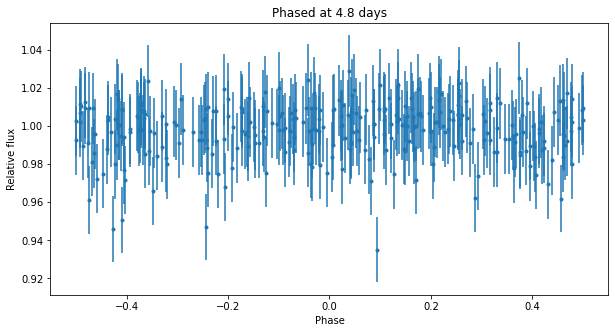

In [31]:
plt.figure(figsize = (10,5))
plt.xlabel('Phase')
plt.ylabel('Relative flux')
plt.errorbar(phases, f, ferr, fmt ='.')
plt.title('Phased at 4.8 days')

In [32]:
P, t0 = 11.24, 2459198.51299

# Get phases:
phases = ((t - np.median(t0))/np.median(P)) % 1
ii = np.where(phases>=0.5)[0]
phases[ii] = phases[ii]-1.0

Text(0.5, 1.0, 'Phased at 11.24 days')

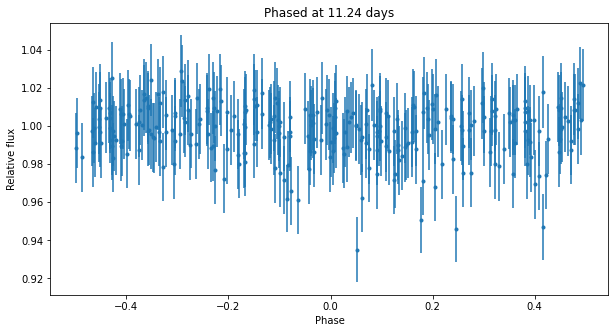

In [33]:
plt.figure(figsize = (10,5))
plt.xlabel('Phase')
plt.ylabel('Relative flux')
plt.errorbar(phases, f, ferr, fmt ='.')
plt.title('Phased at 11.24 days')

bin data in phase?

In [34]:
import juliet

/Users/nespinoza/opt/anaconda3/envs/newen/lib/python3.7/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


(0.98, 1.02)

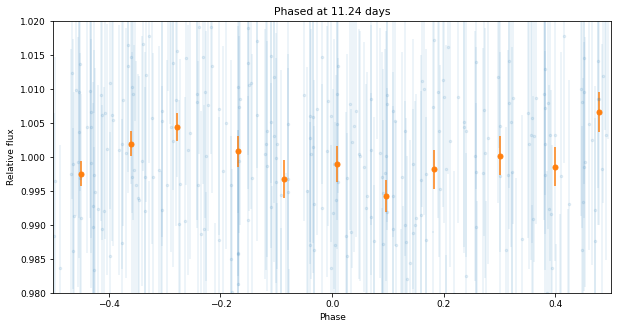

In [35]:
plt.figure(figsize = (10,5))
plt.xlabel('Phase')
plt.ylabel('Relative flux')
idx = np.argsort(phases)
pbin,ybin,yerrbin = juliet.utils.bin_data(phases[idx], f[idx], n_bin = 30)
plt.errorbar(phases, f, ferr, fmt ='.', alpha = 0.1)
plt.errorbar(pbin, ybin, yerrbin, fmt = 'o')
plt.title('Phased at 11.24 days')
plt.xlim(-0.5,0.5)
plt.ylim(0.98,1.02)

In [36]:
P, t0 = 4.8, 2459198.51299

# Get phases:
phases = ((t - np.median(t0))/np.median(P)) % 1
ii = np.where(phases>=0.5)[0]
phases[ii] = phases[ii]-1.0

(0.98, 1.02)

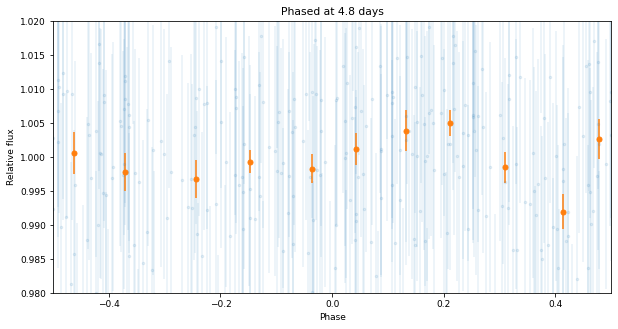

In [37]:
plt.figure(figsize = (10,5))
plt.xlabel('Phase')
plt.ylabel('Relative flux')
idx = np.argsort(phases)
pbin,ybin,yerrbin = juliet.utils.bin_data(phases[idx], f[idx], n_bin = 30)
plt.errorbar(phases, f, ferr, fmt ='.', alpha = 0.1)
plt.errorbar(pbin, ybin, yerrbin, fmt = 'o')
plt.title('Phased at 4.8 days')
plt.xlim(-0.5,0.5)
plt.ylim(0.98,1.02)

## TESS photometry analysis

Let's repeat for TESS:

In [51]:
t, f, ferr = juliet.utils.get_all_TESS_data('HATS-5b')

times = np.append(t['TESS5'], t['TESS32'])
fluxes = np.append(f['TESS5'], f['TESS32'])
ferror = np.append(ferr['TESS5'], ferr['TESS32'])

Remove transits:

In [52]:
P, t0 = 4.76339146, 2459198.51299

# Get phases:
phases = ((times - np.median(t0))/np.median(P)) % 1
ii = np.where(phases>=0.5)[0]
phases[ii] = phases[ii]-1.0
    
# Get phases out-of-transit --- assume Tdur = 4 hours just in case:
idx = np.where( np.abs(phases) * P * 24. >= 2. )[0]

In [53]:
times, fluxes, ferror = times[idx], fluxes[idx], ferror[idx]

In [54]:
# Get phases:
phases = ((times - np.median(t0))/np.median(P)) % 1
ii = np.where(phases>=0.5)[0]
phases[ii] = phases[ii]-1.0

(-10.0, 10.0)

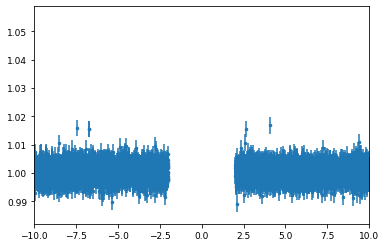

In [55]:
plt.errorbar(phases * P * 24., fluxes, ferror, fmt = '.')
plt.xlim(-10.,10.)

Text(0.5, 1.0, 'Sector 5')

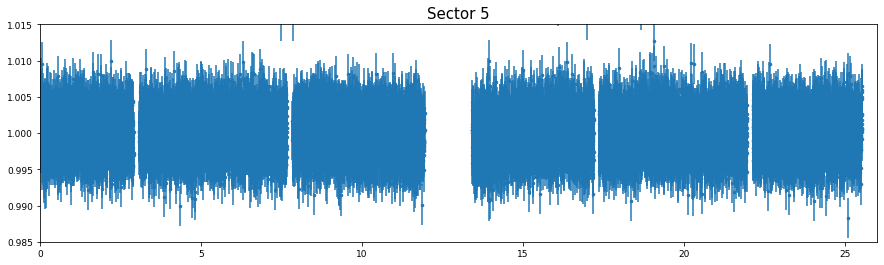

In [66]:
plt.figure(figsize=(15,4))
plt.errorbar(times - times[0], fluxes, ferror, fmt = '.')
plt.xlim(0,26)
plt.ylim(0.985,1.015)
plt.title('Sector 5', fontsize = 15)

Text(0.5, 1.0, 'Sector 32')

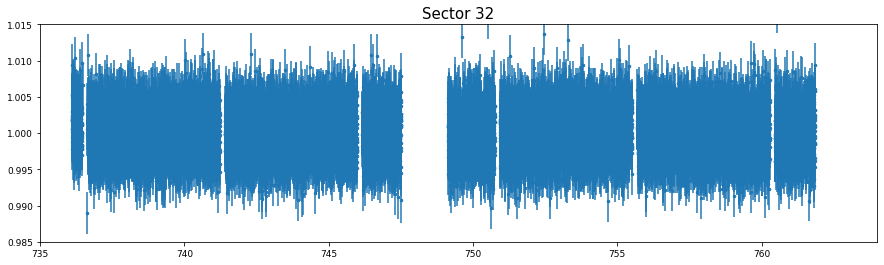

In [65]:
plt.figure(figsize=(15,4))
plt.errorbar(times - times[0], fluxes, ferror, fmt = '.')
plt.xlim(735,764)
plt.ylim(0.985,1.015)
plt.title('Sector 32', fontsize = 15)

Let's do a close-up to the gap in Sector 5:

Text(0.5, 1.0, 'Sector 5 (close-up)')

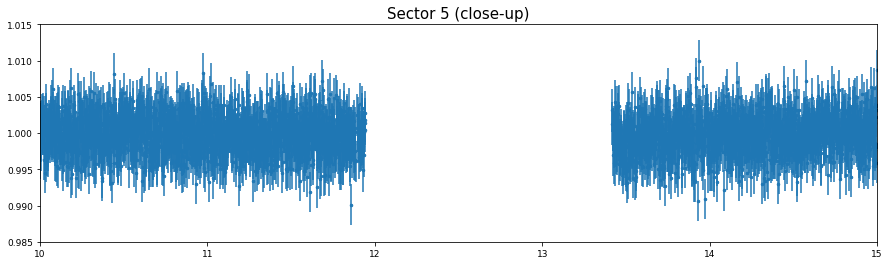

In [67]:
plt.figure(figsize=(15,4))
plt.errorbar(times - times[0], fluxes, ferror, fmt = '.')
plt.xlim(10,15)
plt.ylim(0.985,1.015)
plt.title('Sector 5 (close-up)', fontsize = 15)

Text(0.5, 1.0, 'Sector 32 (close-up)')

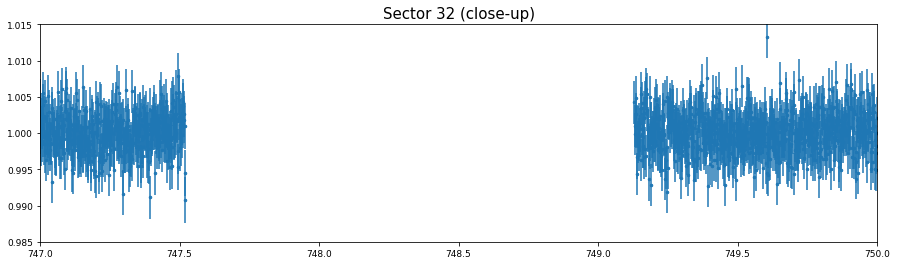

In [69]:
plt.figure(figsize=(15,4))
plt.errorbar(times - times[0], fluxes, ferror, fmt = '.')
plt.xlim(747,750)
plt.ylim(0.985,1.015)
plt.title('Sector 32 (close-up)', fontsize = 15)

In [70]:
dt = times - times[0]

idx1 = np.where(dt<10)[0]
idx2 = np.where((dt>15)&(dt<747))[0]
idx3 = np.where(dt>750)[0]

In [72]:
t, f, ferr = np.append(times[idx1], times[idx2]), np.append(fluxes[idx1], fluxes[idx2]), np.append(ferror[idx1], ferror[idx2])

In [73]:
t = np.append(t, times[idx3])
f = np.append(f, fluxes[idx3])
ferr = np.append(ferr, ferror[idx3])

(0.985, 1.015)

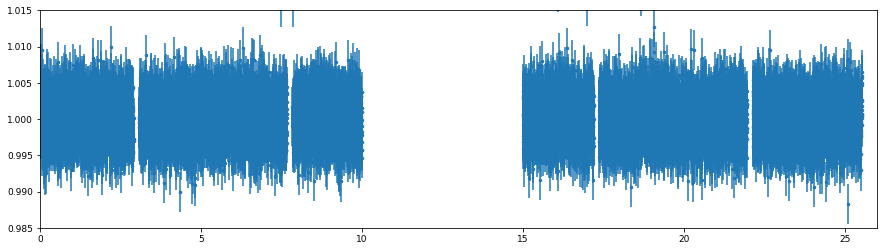

In [75]:
plt.figure(figsize=(15,4))
plt.errorbar(t-t[0], f, ferr, fmt = '.')
plt.xlim(0,26)
plt.ylim(0.985,1.015)

(0.985, 1.015)

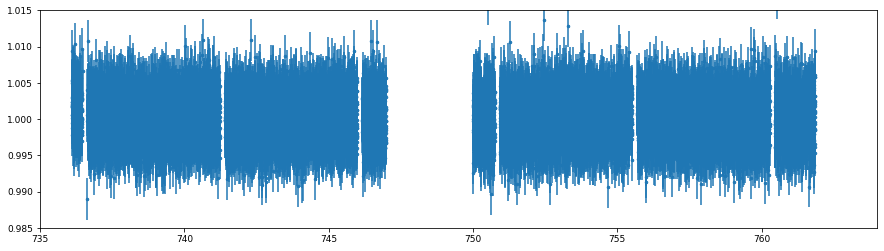

In [76]:
plt.figure(figsize=(15,4))
plt.errorbar(t-t[0], f, ferr, fmt = '.')
plt.xlim(735,764)
plt.ylim(0.985,1.015)

In [149]:
min_timescale = 0.1#np.min(np.abs(np.diff(t))) * 2. # Min timescale given by difference of time-stamps.
max_timescale = 30. # Max timescale given by baseline.

frequency = np.linspace(1. / max_timescale, 1. / min_timescale, 5000)

In [150]:
np.min(frequency)

0.03333333333333333

In [151]:
power = LombScargle(t-t[0], f, ferr).power(frequency)

0.1 30.0
0.03333333333333333 10.0


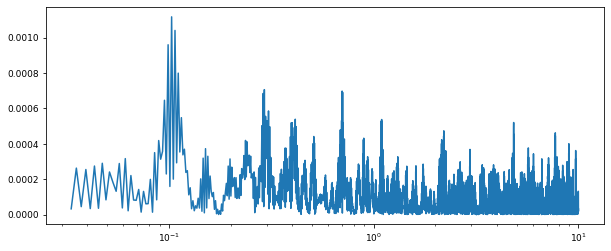

In [154]:
plt.figure(figsize=(10,4))
plt.plot(frequency, power)
print(min_timescale, max_timescale)
print(np.min(frequency), np.max(frequency))
plt.xscale('log')

0.1 30.0
0.03333333333333333 10.0


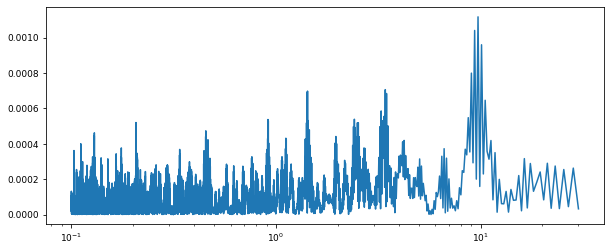

In [153]:
plt.figure(figsize=(10,4))
plt.plot(1./frequency, power)
print(min_timescale, max_timescale)
print(np.min(frequency), np.max(frequency))
plt.xscale('log')

In [155]:
nsimulations = 5000
simulated_datasets = mock_dataset(np.median(f), ferr, nsim = nsimulations)

In [156]:
simulated_psds = np.zeros([nsimulations, len(frequency)])

for i in range(nsimulations):
    simulated_psds[i, :] = LombScargle(t, simulated_datasets[i, :], ferr).power(frequency)

In [157]:
nfrequencies = len(frequency)

limit_999 = np.zeros(nfrequencies)
limit_99 = np.zeros(nfrequencies)
limit_90 = np.zeros(nfrequencies)

for i in range(nfrequencies):

    idx = np.argsort(simulated_psds[:, i])

    idx_999 = idx[int(nsimulations * 0.999)]   
    idx_99 = idx[int(nsimulations * 0.99)]
    idx_90 = idx[int(nsimulations * 0.90)]

    limit_999[i] = simulated_psds[idx_999, i]
    limit_99[i] = simulated_psds[idx_99, i]
    limit_90[i] = simulated_psds[idx_90, i]

Text(0, 0.5, 'PSD')

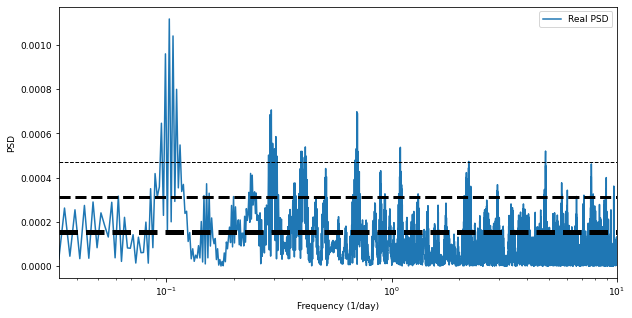

In [158]:
plt.figure(figsize = (10,5))
plt.plot(frequency, power, label = 'Real PSD')
plt.plot([np.min(frequency), np.max(frequency)], [np.median(limit_999), np.median(limit_999)], '--', color='black', lw = 1)
plt.plot([np.min(frequency), np.max(frequency)], [np.median(limit_99), np.median(limit_99)], '--', color='black', lw = 3)
plt.plot([np.min(frequency), np.max(frequency)], [np.median(limit_90), np.median(limit_90)], '--', color='black', lw = 5)
plt.legend()
plt.xlim(np.min(frequency), np.max(frequency))
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Frequency (1/day)')
plt.ylabel('PSD')

(0.7, 0.702)

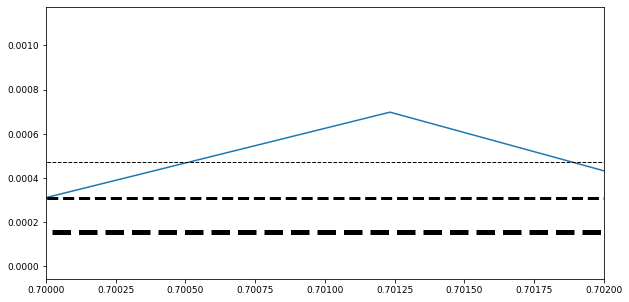

In [173]:
plt.figure(figsize = (10,5))
plt.plot(frequency, power, label = 'Real PSD')
plt.plot([np.min(frequency), np.max(frequency)], [np.median(limit_999), np.median(limit_999)], '--', color='black', lw = 1)
plt.plot([np.min(frequency), np.max(frequency)], [np.median(limit_99), np.median(limit_99)], '--', color='black', lw = 3)
plt.plot([np.min(frequency), np.max(frequency)], [np.median(limit_90), np.median(limit_90)], '--', color='black', lw = 5)

plt.xlim(0.7,0.702)

In [161]:
idx = np.where(power == np.max(power))[0]
frequency[idx]

array([0.10311396])

In [162]:
1./0.10311396

9.698007912798616

In [174]:
1./0.70125

1.4260249554367201

In [175]:
WF_power = []

omega = 1./ np.logspace(np.log10(min_timescale), np.log10(max_timescale),  num=len(frequency))

for omi in 2*np.pi*omega: 

    phase = (t - t[0]) * omi
    WC = np.sum(np.cos(phase))
    WS = np.sum(np.sin(phase))
    WF_power.append((WC**2 + WS**2)/len(t)**2) 
 
WF_power = np.array(WF_power)

(0.0, 0.05)

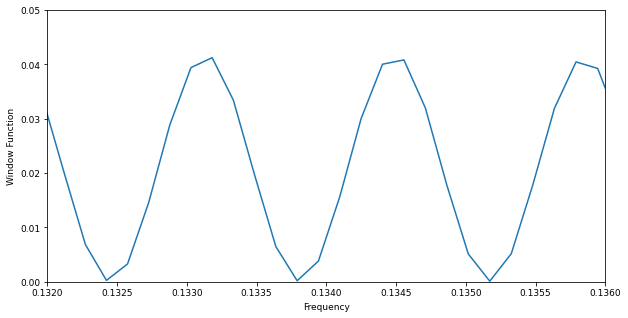

In [190]:
plt.figure(figsize = (10,5))
plt.plot(omega, WF_power, label = 'Window Function')
plt.xlabel('Frequency')
plt.ylabel('Window Function')
#plt.xscale('log')
plt.xlim(0.132,0.136)
plt.ylim(0,0.05)

In [191]:
1./0.1330

7.518796992481203

In [194]:
falias =  0.133

In [197]:
possible_periods = [13.7, 9.70, 3.47, 1.43]
falias = frequency[idx][0]

print('All peaks in the periodogram:',possible_periods)
print('')
for period in possible_periods:
    print('Period under test:',period)
    print('---------------------------')
    print('Aliases at + 1')
    print(1. / ((1. / period) + falias),'days')
    print('Aliases at - 1')
    print(1. / ((1. / period) - falias),'days')
    print('Aliases at + 2')
    print(1. / ((1. / period) + 2*falias),'days')
    print('Aliases at - 2')
    print(1. / ((1. / period) - 2*falias),'days') 
    print('Aliases at + 3')
    print(1. / ((1. / period) + 3*falias),'days')
    print('Aliases at - 3')
    print(1. / ((1. / period) - 3*falias),'days') 
    print('')
    print('')

All peaks in the periodogram: [13.7, 9.7, 3.47, 1.43]

Period under test: 13.7
---------------------------
Aliases at + 1
5.678377057752493 days
Aliases at - 1
-33.199147475713715 days
Aliases at + 2
3.5813974811202547 days
Aliases at - 2
-7.505523416803169 days
Aliases at + 3
2.6155102907501635 days
Aliases at - 3
-4.231028228148082 days


Period under test: 9.7
---------------------------
Aliases at + 1
4.849502018196437 days
Aliases at - 1
-47230.81168829878 days
Aliases at + 2
3.232890697990717 days
Aliases at - 2
-9.696017372340226 days
Aliases at + 3
2.4246265328205094 days
Aliases at - 3
-4.848506361312977 days


Period under test: 3.47
---------------------------
Aliases at + 1
2.555594438699823 days
Aliases at - 1
5.403346820348309 days
Aliases at + 2
2.0226031963290008 days
Aliases at - 2
12.201590908664608 days
Aliases at + 3
1.6735664844638807 days
Aliases at - 3
-47.264719025198275 days


Period under test: 1.43
---------------------------
Aliases at + 1
1.2462384544435168

In [198]:
P, t0 = 9.7, 2459198.51299

# Get phases:
phases = ((t - np.median(t0))/np.median(P)) % 1
ii = np.where(phases>=0.5)[0]
phases[ii] = phases[ii]-1.0

(0.998, 1.002)

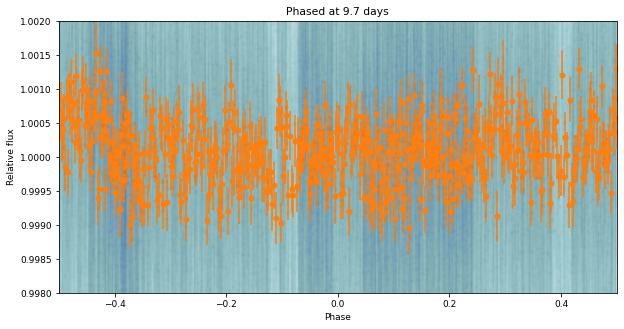

In [204]:
plt.figure(figsize = (10,5))
plt.xlabel('Phase')
plt.ylabel('Relative flux')
idx = np.argsort(phases)
pbin,ybin,yerrbin = juliet.utils.bin_data(phases[idx], f[idx], n_bin = 60)
plt.errorbar(phases, f, ferr, fmt ='.', alpha = 0.01)
plt.errorbar(pbin, ybin, yerrbin, fmt = 'o')
plt.title('Phased at 9.7 days')
plt.xlim(-0.5,0.5)
plt.ylim(0.998,1.002)

In [205]:
P, t0 = 3.47, 2459198.51299

# Get phases:
phases = ((t - np.median(t0))/np.median(P)) % 1
ii = np.where(phases>=0.5)[0]
phases[ii] = phases[ii]-1.0

(0.998, 1.002)

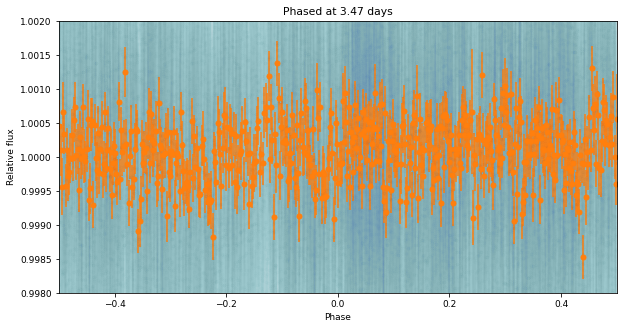

In [207]:
plt.figure(figsize = (10,5))
plt.xlabel('Phase')
plt.ylabel('Relative flux')
idx = np.argsort(phases)
pbin,ybin,yerrbin = juliet.utils.bin_data(phases[idx], f[idx], n_bin = 60)
plt.errorbar(phases, f, ferr, fmt ='.', alpha = 0.01)
plt.errorbar(pbin, ybin, yerrbin, fmt = 'o')
plt.title('Phased at 3.47 days')
plt.xlim(-0.5,0.5)
plt.ylim(0.998,1.002)

In [208]:
P, t0 = 1.43, 2459198.51299

# Get phases:
phases = ((t - np.median(t0))/np.median(P)) % 1
ii = np.where(phases>=0.5)[0]
phases[ii] = phases[ii]-1.0

(0.998, 1.002)

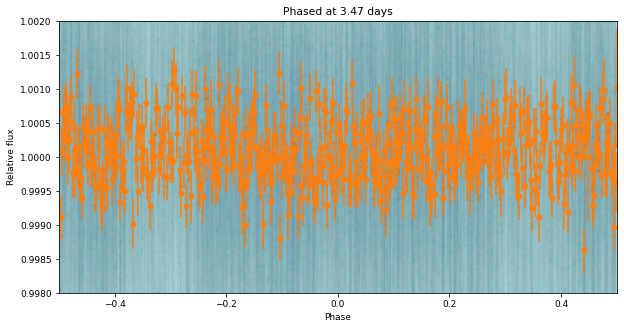

In [209]:
plt.figure(figsize = (10,5))
plt.xlabel('Phase')
plt.ylabel('Relative flux')
idx = np.argsort(phases)
pbin,ybin,yerrbin = juliet.utils.bin_data(phases[idx], f[idx], n_bin = 60)
plt.errorbar(phases, f, ferr, fmt ='.', alpha = 0.01)
plt.errorbar(pbin, ybin, yerrbin, fmt = 'o')
plt.title('Phased at 3.47 days')
plt.xlim(-0.5,0.5)
plt.ylim(0.998,1.002)

In [210]:
P, t0 = 11.8, 2459198.51299

# Get phases:
phases = ((t - np.median(t0))/np.median(P)) % 1
ii = np.where(phases>=0.5)[0]
phases[ii] = phases[ii]-1.0

(0.998, 1.002)

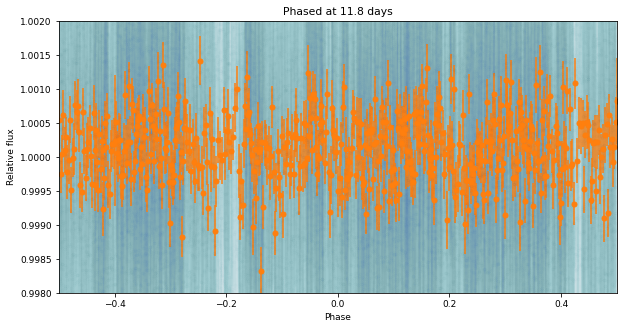

In [211]:
plt.figure(figsize = (10,5))
plt.xlabel('Phase')
plt.ylabel('Relative flux')
idx = np.argsort(phases)
pbin,ybin,yerrbin = juliet.utils.bin_data(phases[idx], f[idx], n_bin = 60)
plt.errorbar(phases, f, ferr, fmt ='.', alpha = 0.01)
plt.errorbar(pbin, ybin, yerrbin, fmt = 'o')
plt.title('Phased at 11.8 days')
plt.xlim(-0.5,0.5)
plt.ylim(0.998,1.002)